In [2]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

import torch
from torcheeg.models import EEGNet
from torcheeg.models import DGCNN
from torcheeg import transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from dtw import dtw
from alphacsc import learn_d_z
try:
    from alphacsc.utils import construct_X
except:
    from alphacsc.utils.convolution import construct_X


In [3]:
import sys 
sys.path.append("/home/aurelien.stumpf/Development/BCI_Classification/")
from eeg_project_package import dataset, models, spectral_analysis, training

In [4]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)
importlib.reload(spectral_analysis)

<module 'eeg_project_package.spectral_analysis' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/spectral_analysis.py'>

## Check Loading of Physio Dataset Files

In [16]:
def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))
    plt.show()

Number of channels:  64
Number of samples:  64


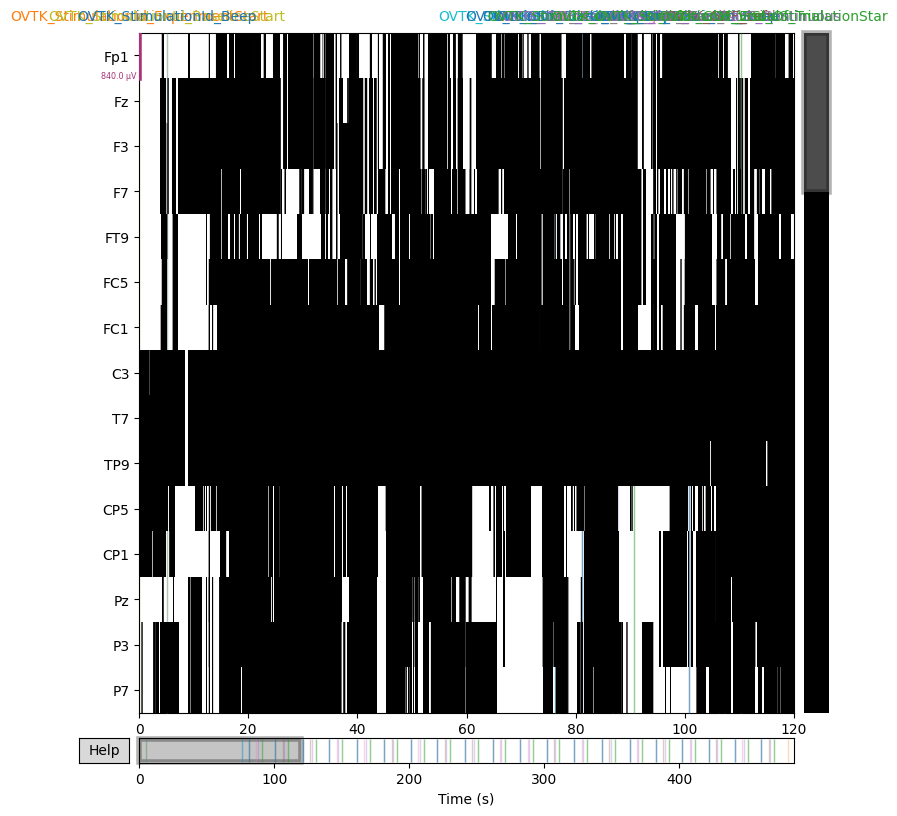

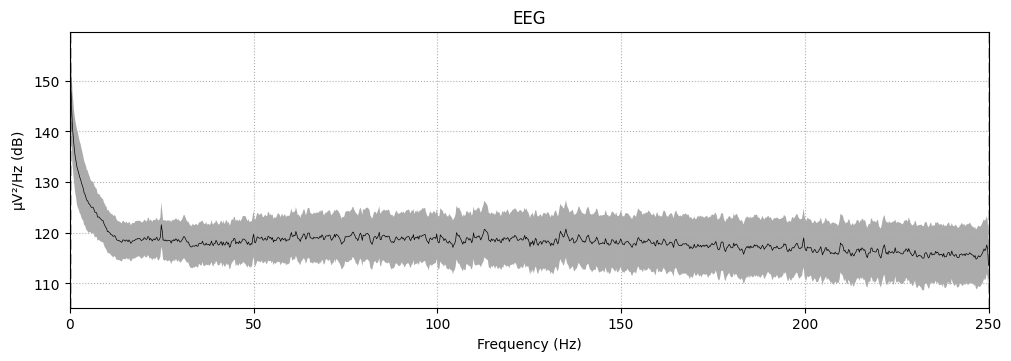

In [5]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.46.29].edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname1, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

# list of all channel names
list_all_ch_names = raw_obj.ch_names

# Signal Analysis

In [8]:
# Define the subject and the session
num_subject = 1
num_session = 3
print("Subject: ", num_subject, " Session: ", num_session)

# Define the path to the data and the train and test files
if num_subject < 10:
    subject_number = "0" + str(num_subject)
else:
    subject_number = str(num_subject)
session_number = "0" + str(num_session)
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/sub-{}/ses-{}/EEG/".format(subject_number, session_number)
files = [folder_path + f for f in os.listdir(folder_path) if f.endswith('.edf') and not(f.startswith("._"))]

# Define the channels
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
list_idx_channels = [list_all_ch_names.index(ch) for ch in list_name_channels]

# Define the labels
labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

# Define the parameters of the dataset
feature_type = ["time"]
dict_preprocessing = {"polynomial_degree":10,"tmin":0,"tmax":4}
dict_features = {"type_psd":"welch","fs":500,"nfft":300,"noverlap":150,"nperseg":300,"filter_order":19,"fmin":4,"fmax":30}

# Create the dataset
trainset = dataset.EEG_Dataset(files_list = files, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = feature_type, dict_preprocessing = dict_preprocessing, dict_features = dict_features)



Subject:  1  Session:  3
Extracting EEG data


Preprocessing EEG data


In [9]:
X = trainset.features["time"]
labels = trainset.labels

In [51]:
# Select signals with label 0
signal = X[labels == 0,5,:]
data = signal[:]
n_atoms = 10  # K
atom_length = 200  # L
penalty = 3  # lambda

# learning a dictionary and codes
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=data,
    n_atoms=n_atoms,
    n_times_atom=atom_length,
    reg=penalty,
    n_iter=30,
    n_jobs=4,
    verbose=1)

V_0/30 .............................


In [50]:
print(signal.shape)

(140, 2001)


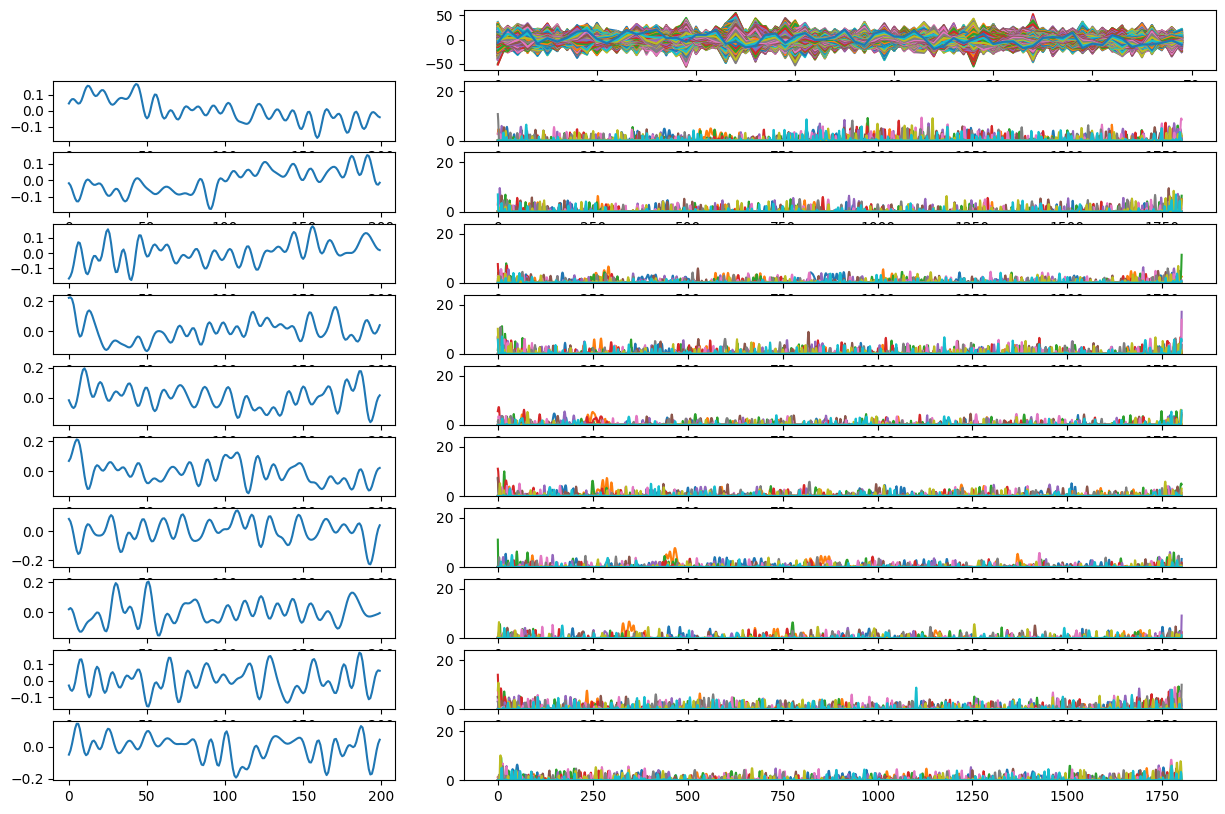

In [52]:
# plot the results
plot_CDL(signal, z_hat.T.squeeze(), d_hat.T.squeeze())

In [55]:
# Select signals with label 1
signal = X[labels == 1,5,:]
data = signal[:]
n_atoms = 10  # K
atom_length = 200  # L
penalty = 10  # lambda

# learning a dictionary and codes
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=data,
    n_atoms=n_atoms,
    n_times_atom=atom_length,
    reg=penalty,
    n_iter=30,
    n_jobs=4,
    verbose=1)

V_0/30 .............................


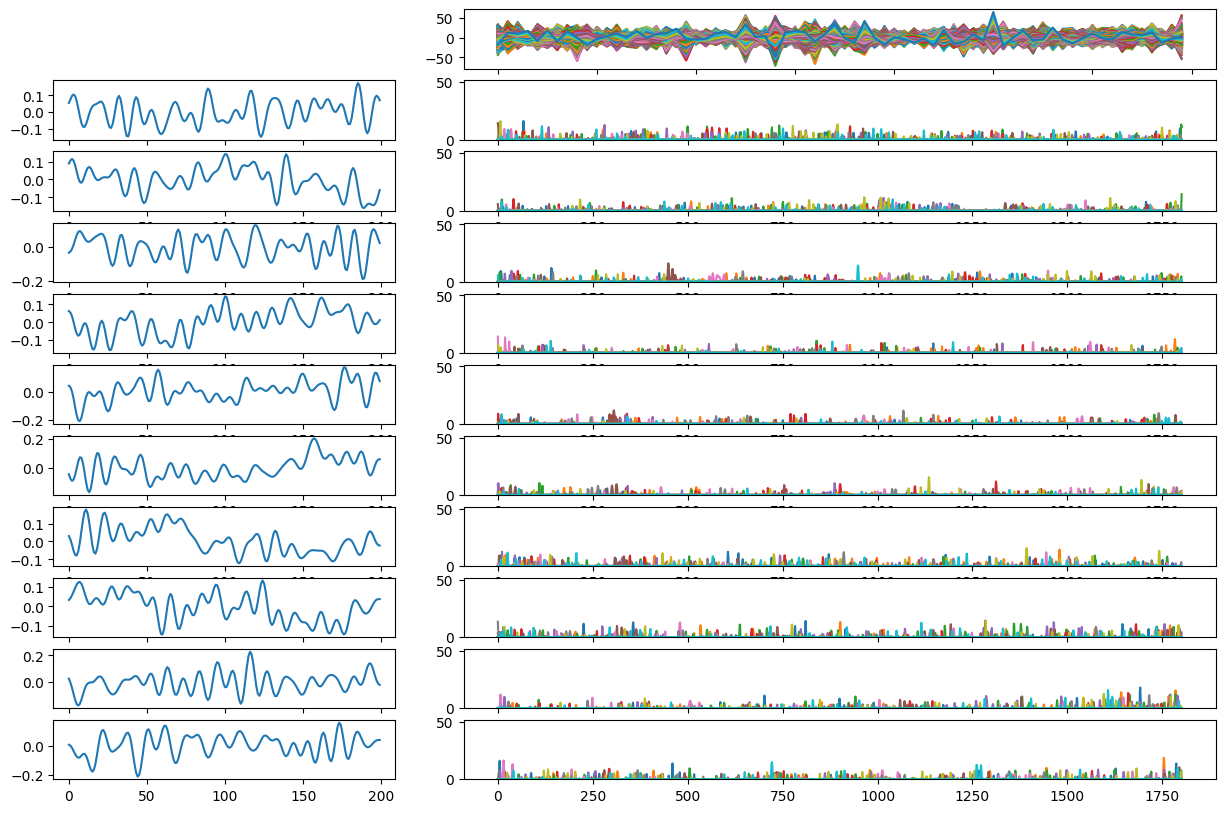

In [56]:
# plot the results
plot_CDL(signal, z_hat.T.squeeze(), d_hat.T.squeeze())

# DTW clustering

In [35]:
def get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray) -> float:
    """Return the DTW distance between two signals."""
    return dtw(signal_1, signal_2, dist= lambda x,y : np.linalg.norm(x - y))

In [34]:
data = X[:,0,:]

distance_matrix = sc.spatial.distance.pdist(
    data, metric=get_dtw_distance
)

AttributeError: 'tuple' object has no attribute 'distance'

In [45]:
get_dtw_distance(data[0], data[13])

(7925.496780400744,
 array([[ 8.08116521,  7.8959043 ,  7.56051429, ..., 37.4014305 ,
         37.94565908, 38.00311257],
        [ 3.2523669 ,  3.067106  ,  2.73171599, ..., 32.57263219,
         33.11686077, 33.17431426],
        [ 2.16870269,  2.3539636 ,  2.68935361, ..., 27.1515626 ,
         27.69579118, 27.75324467],
        ...,
        [ 7.71287704,  7.89813794,  8.23352795, ..., 21.60738826,
         22.15161683, 22.20907033],
        [ 7.8463024 ,  8.03156331,  8.36695332, ..., 21.47396289,
         22.01819147, 22.07564496],
        [ 7.52398647,  7.70924738,  8.04463739, ..., 21.79627882,
         22.3405074 , 22.39796089]]),
 array([[8.08116521e+00, 1.59770695e+01, 2.35375838e+01, ...,
         3.74783837e+04, 3.75163293e+04, 3.75543324e+04],
        [1.13335321e+01, 1.11482712e+01, 1.38799872e+01, ...,
         2.81338526e+04, 2.81669695e+04, 2.82001438e+04],
        [1.35022348e+01, 1.35022348e+01, 1.38376248e+01, ...,
         1.85344369e+04, 1.85621327e+04, 1.85898860

In [39]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])